# Keras implementation of CapsNet
##### `Dynamic Routing Between Capsules` by Sabour, Frosst and Hinton, in NIPS 2017

### PLAN:
* implement reshaping 3D tensor (output of regular Conv2D into 32 6x6x8 capsules (or preferably, 32 36x8 capsules, so in fact make it (32x36)x8 **DONE**
* implement a capsule layer with forward pass = dynamic routing
    - implement squash function **DONE**
    - implement weight sharing between capsules in each of 32 groups **LOOKS LIKE DONE? NO IDEA IF IT WORKS CORRECTLY THOUGH**
    - implement dynamic routing **SEEMS DONE, BUT TWICE THERE SEEMS TO BE UNNECESSARY DIMS EXPANSION AND COPYING OF TENSORS. TRY FIXING THIS**
* implement margin loss for digit existence **DONE**
* implement reconstruction loss with masking for depending on learning phase **DONE**
* put it all together into a network **DONE**
* train on MNIST with small data augmentation as described in the paper, use `.fit_generator()`
* reproduce paper results
* visualize some reconstructions
* visualize how reconstructions change with continous change of one of DigitCaps dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras import initializers, Input
from keras.models import Model, Sequential
from keras.layers import Activation, Conv2D, Lambda, Dense, Flatten, Reshape
from keras.engine.topology import Layer
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


In [2]:
# load data

from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_train = x_train / 255.

x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test / 255.

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
i = 590

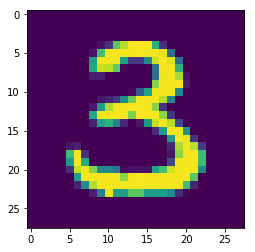

In [4]:
plt.imshow(np.squeeze(x_test[i]))
plt.show()

In [5]:
np.argmax(y_test[i])

3

# Define layers

In [6]:
# utils

def capsule_length(x):
    return K.sqrt(K.sum(K.square(x), axis=-1))

def squash(x):
    l2_norm = K.sum(K.square(x), axis=-1, keepdims=True)
    squash = l2_norm / (1 + l2_norm) * (x / (K.sqrt(l2_norm + K.epsilon())))
    return squash

get_custom_objects().update({'squash': Activation(squash)})

In [7]:
# losses

def margin_loss(lambda_=0.5, m_plus=0.9, m_minus=0.1):
    def margin(y_true, y_pred):
        loss = K.sum(
            y_true * K.square(K.maximum(0., m_plus - y_pred)) + 
            lambda_ * (1 - y_true) * K.square(K.maximum(0., y_pred - m_minus)),
            axis=1,
        )
        return loss
    return margin

def reconstruction_loss(y_true, y_pred):
    return K.sum(K.square(y_true  - y_pred), -1)

In [8]:
def PrimaryCaps(
    capsule_dim,
    filters,
    kernel_size, 
    strides=(1,1),
    padding='valid',
):
    
    conv2d = Conv2D(
            filters=filters, 
            kernel_size=kernel_size, 
            strides=strides, 
            padding=padding)
    
    def eval_primary_caps(input_tensor):
        
#         nonlocal conv2d
        x = conv2d(input_tensor)
        reshaped = Reshape((-1, capsule_dim))(x)
        return Lambda(squash)(reshaped)

    return eval_primary_caps

In [9]:
class CapsuleLayer(Layer):
    
    def __init__(
        self, 
        output_capsules, 
        capsule_dim, 
        routing_iterations=3, 
        kernel_initializer='glorot_uniform',
        activation='squash',
        **kwargs
    ):
        self.output_capsules = output_capsules
        self.capsule_dim = capsule_dim
        self.routing_iterations = routing_iterations
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.activation=Activation(activation)
        super(CapsuleLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        
        self.kernel = self.add_weight(
            name='kernel',
            shape=(
                self.output_capsules,
                input_shape[1],
                self.capsule_dim,
                input_shape[2],
            ),
            initializer=self.kernel_initializer,
            trainable=True,
        )
        
        super(CapsuleLayer, self).build(input_shape)
        
    def call(self, x):
        input_shape = K.shape(x)
        x = K.expand_dims(x, axis=1)
        x_tiled = K.tile(x, [1, self.output_capsules, 1, 1])
        U = K.map_fn(lambda x: K.batch_dot(x, self.kernel, axes=[2,3]), elems=x_tiled)
        
        # initialize matrix of b_ij's
        B = K.zeros(shape=(input_shape[0], self.output_capsules, input_shape[1]))
        for i in range(self.routing_iterations):
            V, B_updated = self._routing_single_iter(B, U, i)
            B = B_updated
            
        return V
            
    def _routing_single_iter(self, B, U, i):
        C = K.softmax(B, axis=1)
        S = K.batch_dot(C, U, [2, 2])
        V = self.activation(S)
        if i < self.routing_iterations - 1:
            B = B + K.batch_dot(V, U, [2, 3])
        return V, B
    
    def compute_output_shape(self, input_shape):
        return (None, self.output_capsules, self.capsule_dim)

In [10]:
class ReconstructionMask(Layer):
    def call(self, input_):
        if type(input_) == list and len(input_) == 2:
            x, mask = input_[0], input_[1]
        else:
            x = input_
            len_x = K.sqrt(K.sum(K.square(x), -1))
            mask = K.one_hot(indices=K.argmax(len_x, 1), num_classes=K.shape(x)[1])
        
        return K.batch_flatten(x * K.expand_dims(mask, -1))
    
    
    def compute_output_shape(self, input_):
        if type(input_) == list and len(input_) == 2:
            input_shape = input_[0]
            return (None, input_shape[1] * input_shape[2])
        else:
            return (None, input_[1] * input_[2])

# Define network

In [11]:
def get_capsule_network(input_shape=(28, 28, 1)):
    
    # encoder network
    input_tensor = Input(shape=input_shape, dtype='float32', name='data')
    conv1 = Conv2D(kernel_size=(9,9), strides=(1,1), filters=256, activation='relu')(input_tensor)
#     primary_caps = PrimaryCaps(capsule_dim=8, filters=256, kernel_size=(9,9), strides=(2,2))(conv1)
    
    primary_caps = Conv2D(filters=256, 
            kernel_size=9, 
            strides=2)(conv1)
    primary_caps = Reshape((-1, 8))(primary_caps)
    primary_caps = Lambda(squash)(primary_caps)
    capsule_layer = CapsuleLayer(output_capsules=10, capsule_dim=16)(primary_caps)
    lengths = Lambda(capsule_length, output_shape=(10,), name='digits')(capsule_layer)
    
    input_mask = Input(shape=(10,), name='mask')
    masked_from_labels = ReconstructionMask()([capsule_layer, input_mask])
    masked_by_length = ReconstructionMask()(capsule_layer)
  
    # decoder network
    decoder = Sequential(name='decoder')
    decoder.add(Dense(512, activation='relu', input_shape=(160,)))
    decoder.add(Dense(1024, activation='relu'))
    decoder.add(Dense(784, activation='sigmoid'))
    decoder.add(Reshape(input_shape))
    
    training_model = Model(input_tensor, lengths)
#     training_model = Model([input_tensor, input_mask], [lengths, decoder(masked_from_labels)])
    inference_model = Model(input_tensor, [lengths, decoder(masked_by_length)])

    return training_model, inference_model

In [12]:
capsnet_train, capsnet_inference = get_capsule_network()

dummy_X = np.random.random((1, 28, 28, 1))
dummy_mask = np.array([0]*9 + [1]).reshape(1, 10)
output_train = capsnet_train.predict(dummy_X)
# output_inference = capsnet_inference.predict(dummy_X)

In [13]:
output_train

array([[  8.08482810e-08,   6.19953511e-08,   8.55215490e-08,
          8.55084608e-08,   6.00604793e-08,   5.53650139e-08,
          1.30817924e-07,   1.44476445e-07,   1.41975349e-07,
          9.94171074e-08]], dtype=float32)

In [14]:
capsnet_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 1152, 8)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1152, 8)           0         
_________________________________________________________________
capsule_layer_1 (CapsuleLaye (None, 10, 16)            1474560   
_________________________________________________________________
digits (Lambda)              (None, 10)                0         
Total para

In [15]:
i=0
print(capsnet_train.get_weights()[i].mean())
print(capsnet_train.get_weights()[i].std())
print(capsnet_train.get_weights()[i].shape)

-6.56874e-05
0.00980886
(9, 9, 1, 256)


In [ ]:
# capsnet_train.compile(
#     loss={'digits': margin_loss(), 'decoder': reconstruction_loss},
#     loss_weights={'digits': 1, 'decoder':0.0005}, 
#     optimizer='adam',
#     metrics={'digits': 'acc'}
# )


capsnet_train.compile(
    loss=margin_loss(),
    optimizer='adam',
    metrics={'digits': 'acc'}
)


from keras.preprocessing.image import ImageDataGenerator
def train_generator(x, y, batch_size, shift_fraction=0.):
    train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                       height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while 1:
        x_batch, y_batch = generator.next()
#         yield x_batch, y_batch
#         yield ([x_batch, y_batch], [y_batch, x_batch])

# capsnet_train.fit_generator(generator=train_generator(x_train, y_train, 100, 0.),
#                     steps_per_epoch=int(y_train.shape[0] / 100),
#                     epochs=10,
#                     validation_data=[[x_test, y_test], [y_test, x_test]])


# capsnet_train.fit([x_train, y_train], [y_train, x_train], epochs=10, batch_size=128, validation_data=([x_test, y_test], [y_test, x_test]))
capsnet_train.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 8576/60000 [===>..........................] - ETA: 31:44 - loss: 0.3386 - acc: 0.6206

In [134]:
i=4
print(capsnet_train.get_weights()[i].mean())
print(capsnet_train.get_weights()[i].std())
print(capsnet_train.get_weights()[i].shape)

0.000177686
0.0124434
(10, 1152, 16, 8)


# Playground

In [109]:
x = K.ones((2, 10, 16))

In [110]:
x_ = K.eval(x)
squashed = K.eval(squash(x))

In [111]:
def numpy_squash(x):
    l2_norm = np.sum(x**2, axis=-1, keepdims=True)
    scalar = l2_norm /(1 + l2_norm) / np.sqrt(l2_norm +1e-7)
    return x * scalar

In [112]:
numpy_squash(x_)[0][0]

array([ 0.23529412,  0.23529412,  0.23529412,  0.23529412,  0.23529412,
        0.23529412,  0.23529412,  0.23529412,  0.23529412,  0.23529412,
        0.23529412,  0.23529412,  0.23529412,  0.23529412,  0.23529412,
        0.23529412], dtype=float32)

In [113]:
squashed[0][0]

array([ 0.23529415,  0.23529415,  0.23529415,  0.23529415,  0.23529415,
        0.23529415,  0.23529415,  0.23529415,  0.23529415,  0.23529415,
        0.23529415,  0.23529415,  0.23529415,  0.23529415,  0.23529415,
        0.23529415], dtype=float32)

In [836]:
x = K.random_normal((2, 10, 16))
mask = K.variable(np.array([[1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,1]]))

In [854]:
K.batch_flatten(x * K.expand_dims(mask, -1))

<tf.Tensor 'Reshape_265:0' shape=(?, ?) dtype=float32>

In [301]:
B = K.zeros(shape=(12, 1152, 10))
C =  K.map_fn(lambda x: K.softmax(x, axis=-1), B)

x_batch = K.ones(shape=(12,1152, 8))
x_batch = K.expand_dims(x_batch, axis=2)
x_batch = K.repeat_elements(x_batch, rep=10, axis=2)
y_batch = K.ones(shape=(1152, 10, 8, 16))
xy_batch_dot = K.map_fn(lambda x: K.batch_dot(x, y_batch, axes=[2,2]), x_batch)

C= K.expand_dims(C, axis=-1)
C = K.repeat_elements(C, rep=16, axis=-1)

print(K.int_shape(C))
print(K.int_shape(xy_batch_dot))

S = K.sum(C * xy_batch_dot, axis=1)
S = K.expand_dims(S, axis=1)
S = K.tile(S, [1,1152,1,1])
# S = K.repeat_elements(S, rep=1152, axis=1)

print(K.int_shape(S))
new_B = K.sum(xy_batch_dot*S, axis=-1 )
print(K.int_shape(new_B))

(12, 1152, 10, 16)
(12, 1152, 10, 16)
(12, 1152, 10, 16)
(12, 1152, 10)


In [353]:
dummy_X = np.random.random((32,6,6,256))

input_tensor = Input(shape=input_shape)
reshaped = Reshape((36, 32, 8))(input_tensor)
permuted = Permute((2,1,3))(reshaped)
primary_caps = Reshape(output_shape)(permuted)
digit_caps = CapsuleLayer(10, 16, num_groups=32)(primary_caps)

model = Model(input_tensor, digit_caps)
output = model.predict(dummy_X)

In [354]:
output.shape

(32, 10, 16)

In [327]:
c = CapsuleLayer(10, 16)
c.build((1,1152,8))

In [328]:
c.get_weights()[0].shape

(1152, 10, 8, 16)

In [330]:
c2 = CapsuleLayer(10, 16, num_groups=32)

In [331]:
c2.build((1,1152,8))

In [337]:
W = c2.get_weights()

In [338]:
len(W)

32